# Initialize framework

In [ ]:
from typing import Callable, Optional, List, Union, Dict, Tuple
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import json
import re

#from string import ascii_letters
from string import punctuation

import pandas as pd

# Set pandas option
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Try to use GPU device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

dataset_path  = '/content/drive/MyDrive/DM project - NLP lyrics generation/english_cleaned_lyrics.csv'
word2vec_path = '/content/drive/MyDrive/DM project - NLP lyrics generation/cc.en.300.vec'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Word2vec and vocabulary**

In [ ]:
# Create dictionary and word vector list for word embeddings
VOCABULARY_LEN = 350_000
VECTOR_SIZE    = 300

# Create dictionary and inverse dictionary of words and word vector list for word embeddings
words2indices = {}
indices2words = {}
word_vectors = []

# pad => 0
word_vectors.append(torch.rand(VECTOR_SIZE))

# unk => 1
word_vectors.append(torch.rand(VECTOR_SIZE))

# VECCHIA VERSIONE
'''with open(word2vec_path) as f:
    next(f) 
    for i, l in tqdm(enumerate(f), total=DICTIONARY_WORDS_LEN):
        if i == DICTIONARY_WORDS_LEN:
            break

        word, *vector = l.strip().split(' ')

        if ( not word[0].isupper() ) and ( not any(c for c in word if c not in ascii_letters + "'") ): #and word.isalpha():
          vector = torch.tensor([float(c) for c in vector])
          
          word_idx = len(word_vectors)
          words2indices[word]     = word_idx
          indices2words[word_idx] = word

          word_vectors.append(vector)'''



# Word2vec file contains words (including punctuation and contractions) with some permutations of lower and upper case letters,
# so don't worry about the case that a word may be present only in uppercase letters

contractions = ["i'm", "you're", "he's", "she's", "it's", "we're", "they're",
                "ain't", "aren't", "isn't",
                "don't", "can't",
                "i've", "you've", "we've", "they've",
                "i'd", "you'd", "he'd", "she'd", "it'd", "we'd", "they'd", "where'd",
                "i'll", "you'll", "he'll", "she'll", "it'll", "we'll", "they'll",
                "let's", "what's",
                "'em", "'bout", "'cause"
                ]

with open(word2vec_path) as f:
    next(f) 
    for i, l in tqdm(enumerate(f), total=2000000):
        # Check if the desired vocabulary size has been achieved
        if len(word_vectors) == VOCABULARY_LEN:
          print("Desired vocabulary size achieved, stop vectors iterations!")
          break

        # Get the word and the vector
        word, *vector = l.strip().split(' ')

        # Check if a word is in the word2vec file
        #if word.lower() == 'i':
        #if word.lower() in punctuation:
        #if word.lower() in contractions:
        #if "'" in word:
        #if "’" in word:
        #  print("word: ", word)
        #else:
        #  continue

        skip = False

        # Skip words composed of at least one upper case or non-alpha letter (except contractions)
        if not word in contractions:
          for char in word:
            if char.isupper() or not char.isalpha():
              skip = True
              break

        if not skip:
          #print("Added word: ", word)
          vector = torch.tensor([float(c) for c in vector])
          
          word_idx = len(word_vectors)
          words2indices[word]     = word_idx
          indices2words[word_idx] = word

          word_vectors.append(vector)

words2indices = defaultdict(lambda: 1, words2indices)
word_vectors = torch.stack(word_vectors).cuda()

In [ ]:
# Compute cosine similarity between word and word_vector
def array_cosine_sim(word, vectors):
  num = torch.sum((vectors * word), 1)
  norms = torch.norm(vectors, dim=1)
  word_norm = torch.norm(word)
  den = norms * word_norm
  return torch.argmax(num/den).cuda()

In [ ]:
# Get word from index
def get_word_from_index(idx):
  return indices2words.get(idx)

# Get index from word
def get_index_from_word(word):
  return words2indices.get(word)

# **Dataset**

In [ ]:
SEQUENCE_LENGTH = 6

class Dataset(Dataset):

    def __init__(self, dataset_path: str):
        self.dataset_path = dataset_path
        self.lyrics = []
        self.genres = []
        self.data_input  = []
        self.data_target = []
        self.parse_data()

    # Lyrics preprocessing.
    # Dataset does not include punctuation except contractions such as i'm, it's, isn't, ...
    def lyrics_preprocessing(self, lyrics_text):
      return lyrics_text.lower()

    # ANDRA' MODIFICATO CON LA DIMENSIONE GIUSTA DELLE SEQUENZE
    def lyrics_split_input(self, x):
      #print("lyrics: ", x)
      # Take the first SEQUENCE_LENGTH words of each lyrics
      splitted = x.split()[:SEQUENCE_LENGTH]

      # VALUTARE SE AUMENTARE ESPONENZIALMENTE NUMERO DI SEQUENZE SHIFTANDO VERSO DESTRA DI m POSIZIONI FINCHÈ POSSIBILE

      if len(splitted) < SEQUENCE_LENGTH: 
        return None
      else:
        return [words2indices[word] for word in splitted[:(SEQUENCE_LENGTH-1)]]

    # VERSIONE IN CUI IL TARGET È COSTITUITO DA UNA SINGOLA PAROLA
    def lyrics_split_target(self, x):
      splitted = x.split()[:SEQUENCE_LENGTH]
      if len(splitted) < SEQUENCE_LENGTH: 
        return None
      else:
        return words2indices[splitted[SEQUENCE_LENGTH-1]]

    def parse_data(self):
        # Read CSV file and get column of interest
        data = pd.read_csv(self.dataset_path)
        data = data[['lyrics', 'genre']]

        # Preprocess lyrics
        data['lyrics'] = data['lyrics'].apply(self.lyrics_preprocessing)

        # One hot encode genres
        data = pd.get_dummies(data, columns=['genre'])

        # Instantiate lyrics and genres
        self.lyrics = data[['lyrics']]
        self.genres = data.iloc[:, 1:]

        # Split lyrics in input and target sequences of SEQUENCE_LENGTH words
        input  = data['lyrics'].apply(self.lyrics_split_input)
        target = data['lyrics'].apply(self.lyrics_split_target)
        
        # Remove null rows
        input.dropna(axis=0, inplace=True)
        target.dropna(axis=0, inplace=True)

        # Create tensor for input and target sequences and put them on the GPU
        self.data_input  = torch.tensor(input.tolist(), dtype=torch.long).cuda()
        self.data_target = torch.tensor(target.values, dtype=torch.long).cuda()
        
    def __len__(self):
      return len(self.data_input)

    def __getitem__(self, idx):
        return [self.data_input[idx], self.data_target[idx]]

In [ ]:
# Instantiate train dataset
train_dataset = Dataset(dataset_path=dataset_path)
train_dataloader = DataLoader(train_dataset, batch_size=64)


# NON ABBIAMO TEST DATASET, VALUTARE SE AGGIUNGERLO E USARLO
# OPZIONE 1
'''
dataset = Dataset(dataset_path=file_path)
batch_size      = 64
test_split      = .2
shuffle_dataset = True
random_seed     = 42

# Get split index
dataset_size = len(dataset)
indices = list(range(dataset_size))
split_index = int(np.floor(test_split * dataset_size))

# Shuffle dataset (if necessary)
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Get data indices for training and test splits
train_indices = indices[split_index:]
test_indices  = indices[:split_index]

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler  = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader  = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
'''

# OPZIONE 2
'''
dataset = Dataset(dataset_path=file_path)
dataset_size = len(dataset)
BATCH_SIZE   = 64
TRAIN_SPLIT  = .8
SEED         = 2147483647

train_size = int(train_split * dataset_size)
test_size  = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)
'''

'\ndataset = Dataset(dataset_path=file_path)\ndataset_size = len(dataset)\nBATCH_SIZE   = 64\nTRAIN_SPLIT  = .8\nSEED         = 2147483647\n\ntrain_size = int(train_split * dataset_size)\ntest_size  = dataset_size - train_size\ntrain_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))\n\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size)\ntest_dataloader  = DataLoader(test_dataset, batch_size=batch_size)\n'

# **Models**

In [ ]:
class Generator(nn.Module):

  def __init__(
      self,
      word_vectors: torch.Tensor,
      lstm_hidden_size: int,
      hidden_size: int,
      vocab_size: int
  ):
    super().__init__()
    
    # Embedding layer
    self.embedding = torch.nn.Embedding.from_pretrained(word_vectors)
    
    # Recurrent layer (LSTM)
    self.rnn = torch.nn.LSTM(input_size=word_vectors.size(1), hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)

		# Linear layers
    self.lin1 = torch.nn.Linear(lstm_hidden_size, 4*hidden_size)
    self.lin2 = torch.nn.Linear(4*hidden_size, 2*hidden_size)
    self.lin3 = torch.nn.Linear(2*hidden_size, 2*hidden_size)
    self.lin4 = torch.nn.Linear(2*hidden_size, vocab_size)

    # Dropout function
    self.dropout = nn.Dropout(p=0.1)
		
		# Loss function
    self.loss_fn = torch.nn.CrossEntropyLoss()
    
    self.global_epoch = 0
    
  def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
    # LA y NON VIENE MAI UTILIZZATA!

    #print("gen - forward")

    # Embedding words from indices
    embedding_out = self.embedding(x)

    #print("embedding_out sizes emb: ", embedding_out.size())

		# Recurrent encoding
    recurrent_out = self.rnn(embedding_out)[0]

    #print("embedding_out sizes rnn: ", embedding_out.size())
		
		# Utilize the sequences length to retrieve seq len
    batch_size, seq_len, hidden_size = recurrent_out.shape

		# Flatten recurrent layer output
    flattened_out = recurrent_out.reshape(-1, hidden_size)

		# tensor of the start offsets of each element in the batch
    sequences_offsets = torch.arange(batch_size) * seq_len

    trgs_vectors_indices = sequences_offsets + 4
    
    # getting vectors of target words
    trgs_vectors = flattened_out[trgs_vectors_indices]
    
    out = self.lin1(trgs_vectors)
    out = torch.relu(out)
    out = self.dropout(out)
    out = self.lin2(out)
    out = torch.relu(out)
    out = self.dropout(out)
    out = self.lin3(out)
    out = torch.relu(out)
    out = self.dropout(out)
    out = self.lin4(out).squeeze(1)
    
    logits = out
    pred = torch.softmax(logits, dim=-1)

    '''print("logits: ", logits)
    print("logits size: ", logits.size())
    print("pred: ", pred)
    print("pred size: ", pred.size())
    print("pred type: ", pred.type())'''

    # BISOGNA VERIFICARE LA SHAPE DI OUTPUT E COMPRENDERE COME E' MEGLIO CHE SIA
    # SECONDO ME POTREBBE ESSERE O DIRETTAMENTE IL VETTORE WORD2VEC
    # OPPURE LA PROBABILITA' DI UNA PAROLA (I VETTORI DELLE PAROLE SONO ALL'INTERNO DI word_vectors)
    # AL MOMENTO NON SO CHE COSA ESCE ESATTAMENTE
    
    result = {'logits': logits, 'pred': pred}


    # test
    '''max_value = -1
    for tensor in pred:
      for value in tensor:
        #print("pred value: ", value)
        if value > max_value:
          max_value = value
      break

    print("max_value 1st row: ", max_value)'''



    
    # compute loss
    if y is not None:
      # Max likelihood can return repeated sequences over and over
      #out = torch.argmax(out, dim=1)
      
      # Sample from the multinomial probability distribution of 'logits' (after softmax). 
      # Return the index of the sample (one for each row of the input matrix)
      sampled_indices = torch.multinomial(pred, num_samples=1)

      #print("sampled_indices: ", sampled_indices)
      #print("sampled_indices size: ", sampled_indices.size())

      # Get the samples from the indices
      # NON SERVE PERCHÈ L'INDICE DEL VETTORE CORRISPONDE ALL'INDICE DEL VOCABOLARIO DAL MOMENTO CHE 
      # LA PROBABILITÀ VIENE CALCOLATA SU TUTTE LE PAROLE DEL VOCABOLARIO STESSO
      '''samples = [] 
      sampled_indices_size = sampled_indices.size()[0]
      for i in range(sampled_indices_size):
        tensor = pred[i]
        sample = tensor[ sampled_indices[i] ]
        samples.append([sample])

      print("samples: ", samples)

      # Cast tensor to LongTensor
      pred = torch.tensor(samples).type(torch.LongTensor).cuda()
      print("pred: ", pred)
      print("pred size: ", pred.size())
      print("pred type: ", pred.type())

      result['pred'] = pred'''

      result['pred'] = sampled_indices

      loss = self.loss(out, y)
      result['loss'] = loss
      
    return result
    
  def loss(self, pred, y):
    return self.loss_fn(pred, y)


In [ ]:
class Discriminator(nn.Module):
  
  def __init__(
    self,
		word_vectors: torch.Tensor,
		lstm_hidden_size: int,
		hidden_size: int
	):
    super().__init__()
    
    # embedding layer
    self.embedding = torch.nn.Embedding.from_pretrained(word_vectors)
    
    # recurrent layer
    #self.rnn = torch.nn.LSTM(input_size=word_vectors.size(1), hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
    self.rnn = torch.nn.LSTM(input_size=word_vectors.size(1), hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)
    
    # linear layers
    #self.linear_one = torch.nn.Linear(5*2*lstm_hidden_size, 2*hidden_size)
    self.linear_one = torch.nn.Linear(lstm_hidden_size, hidden_size)
    torch.nn.init.uniform_(self.linear_one.weight)
    self.linear_two = torch.nn.Linear(hidden_size, 1)
    torch.nn.init.uniform_(self.linear_two.weight)
    
    # dropout function
    self.dropout = nn.Dropout(p=0.1)
    
    # loss function
    self.loss_fn = torch.nn.BCELoss()
    
    # sigmoid function
    self.out_act = torch.nn.Sigmoid()
    
    self.global_epoch = 0
    
  def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
    #print("dis - forward")
    
    # embedding words from indices
    embedding_out = self.embedding(x)

    # recurrent encoding
    recurrent_out = self.rnn(embedding_out)[0]

    #print("recurrent_out rnn: ", recurrent_out.size())
    
    # getting sequence length
    batch_size, seq_len, hidden_size = recurrent_out.shape
    
    # flatten embedding layer output
    #flattened_out = recurrent_out.reshape(batch_size, -1)
    flattened_out = recurrent_out.reshape(-1, hidden_size)

    #print("flattened_out: ", flattened_out.size())
    
    sequences_offsets = torch.arange(batch_size) * seq_len
    
    trgs_vectors_indices = sequences_offsets + 4
    
    # getting vectors of target words
    trgs_vectors = flattened_out[trgs_vectors_indices]
    
    # linear layers
    out = self.linear_one(trgs_vectors)
    out = torch.relu(out)
    out = self.dropout(out)
    out = self.linear_two(out).squeeze(1)
    
    out = self.out_act(out)
    pred = torch.round(out)

    #print("pred: ", pred)
    
    result = {'logits': out, 'pred': pred}
    
    # compute loss
    if y is not None:
      loss = self.loss(pred, y)
      result['loss'] = loss
      
      return result
      
  def loss(self, pred, y):
    return self.loss_fn(pred, y)

# **Training loop**

In [ ]:
def train_and_evaluate(
    generator:     nn.Module,
    discriminator: nn.Module,
    gen_optimizer: torch.optim.Optimizer,
    dis_optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 5,
    verbose: bool = True,
):
    gen_train_history = []
    dis_train_history = []

    for epoch in range(epochs):
        gen_losses = []
        dis_losses = []

        j = 0

        # Iterate batches of the training set
        for x, y in tqdm(train_dataloader):
          x_fake = x
          y_gen = 0

          input_batch_size = x.size()[0]
          target_real = torch.ones([input_batch_size]).cuda()
          target_fake = torch.zeros([input_batch_size]).cuda()


          # Append the generated word to the input sequence (removing the head)
          # OPZIONE 0
          '''batch_out = gen(x_fake)
          argm = torch.argmax(batch_out['pred'], dim=1).unsqueeze(1)
          y_gen = argm
          x_fake = x_fake[:, 1:]
          x_fake = torch.cat((x_fake, argm), 1)'''


          # five words generation through moving window (MA QUI NON USIAMO MAI IL TARGET PER IL GENERATORE)
          # OPZIONE 1
          '''for i in range(SEQUENCE_LENGTH):
            batch_out = generator(x_fake.detach())
            argm = torch.argmax(batch_out['pred'], dim=1).unsqueeze(1)
            print("argm: ", argm)
            print("argm type: ", argm.type())
            if i == 0:
              y_gen = argm
            x_fake = x_fake[:, 1:]
            x_fake = torch.cat((x_fake, argm), 1)#'''

          # OPZIONE 2
          #for i in range(SEQUENCE_LENGTH):
          for i in range(1):
            if i == 0:
              #batch_out = generator(x_fake.detach(), y)
              batch_out = generator(x_fake, y)
              pred = batch_out['pred']
              y_gen = batch_out['pred']
            else:
              batch_out = generator(x_fake.detach())
              pred = torch.multinomial(y['pred'], num_samples=1).item()
              # QUI NON SAPREI CHE y METTERE.
              # PER IL MOMENTO LASCIO SOLO UN'ITERAZIONE,
              # QUINDI LA SEQUENZA È QUELLA DI INPUT SENZA TESTA E CON IN CODA LA PAROLA GENERATA

            # Append the generated word to the input sequence (removing the head)
            x_fake = x_fake[:, 1:]
            x_fake = torch.cat((x_fake, pred), 1)#'''
            
          # Every 10 batches
          if j % 10 == 0:
            # Train the generator
            # We invert the labels here and don't train the discriminator because we want the generator
            # to make things the discriminator classifies as true.
            
            # zero the gradients on each iteration
            gen_optimizer.zero_grad()

            generator_discriminator_out = discriminator(x_fake, target_real)
            gen_loss = generator_discriminator_out['loss']
            gen_loss.backward()
            gen_optimizer.step()

          # Train the discriminator on the true/generated data
          dis_optimizer.zero_grad()
          true_discriminator_out = discriminator(x, target_real)
          true_discriminator_loss = true_discriminator_out['loss']

          # add .detach() here think about this
          generator_discriminator_out = discriminator(x_fake.detach(), target_fake)
          generator_discriminator_loss = generator_discriminator_out['loss']
          #dis_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
          dis_loss = torch.mean(true_discriminator_out['logits']) - torch.mean(generator_discriminator_out['logits']) # Wasserstein loss
          dis_loss.backward()
          dis_optimizer.step()

          j += 1




          


          '''
          # DISCRIMINATOR TRAINING

          # Verificare come implementare queste operazioni

          #############
          # NOTARE CHE IL GENERATORE RITORNA UNA PAROLA, MENTRE IL DISCRIMINATORE NE VUOLE 5
          # INTERPOLATES SOTTRAE LA Y GENERATA A QUELLA TARGET, QUINDI AVRA' UNA DIMENSIONE DI UNA PAROLA
          # TUTTAVIA POI VIENE PASSATA AL DISCRIMINATORE, CHE NE VUOLE 5. COME FARE?
          alpha = torch.rand(y.size()).cuda()
          differences = torch.sub(y_gen.squeeze(), y)
          interpolates = y + (alpha * differences)

          # E' SBAGLIATO!!!! SOLO PER PROVARE SE VA #################
          interpolates = interpolates.unsqueeze(1)
          test_interpolates = torch.cat((interpolates, interpolates, interpolates, interpolates, interpolates), dim=1).int()
          print(test_interpolates[:10])
          #############################

          # Compute gradient penalty
          loss = dis(test_interpolates, target_real)['loss'] ### SBAGLIATO!!! IL TARGET NON CI VA. SOLO PER PROVA. INOLTRE 'loss' DA ERRORE PERCHE' NON ABBIAMO IL TARGET DI SOLITO
          dis_optimizer.zero_grad()
          loss.backward()
          dis_optimizer.step()

          gradients = interpolates.grad[0]
          norm = torch.sqrt( torch.sum(torch.square(gradients), dim=1, keepdim=True) )
          gradient_penalty = torch.mean((norm - 1.0) ** 2)

          ##### TF VERSION
          #gradients = gp_tape.gradient(dis(interpolates)['logits'], dis.trainable_variables)[0]    
          #norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), 1, keepdims=True))
          #gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
          #####
          #############


          # discriminator predict
          y_real = dis(x, target_real)
          y_fake = dis(x_fake, target_fake)


          # Wasserstein loss
          dis_loss = torch.mean(y_fake['logits']) - torch.mean(y_real['logits'])
          #d_loss = dis_loss + gradient_penalty * 10
          dis_loss += gradient_penalty * 10

          #### TF VERSION
          # Wasserstein loss
          # dis_loss = tf.reduce_mean(y_dis_fake_logits) - tf.reduce_mean(y_dis_real_logits)
          #d_loss = dis_loss + gradient_penalty * 10
          ####
          '''

          # computes the gradient of the loss (dobbiamo usare la wasserstein)
          '''dis_loss_real = y_real['loss']
          dis_losses.append(dis_loss_real)
          dis_loss_real.backward()

          dis_loss_fake = y_fake['loss']
          dis_losses.append(dis_loss_fake)
          dis_loss_fake.backward()'''
          ###

          '''
          #dis_optimizer.zero_grad() # questo va rimesso?
          #d_loss.backward()
          dis_loss.backward()

          # updates parameters based on the gradient information
          dis_optimizer.step()


          # GENERATOR TRAINING
          
          # proviamo a riutilizzare precedenti risultati di generazione e discriminazione
          gen_loss = -torch.mean(y_fake['logits'])

          # generiamo nuovamente e discriminiamo nuovamente
          # ...

          # Compute generator gradient
          gen_optimizer.zero_grad()
          gen_loss.backward()

          # Update the weights of the generator using the generator optimizer
          gen_optimizer.step()
          '''

          # Track progress
          gen_losses.append(gen_loss)
          dis_losses.append(dis_loss)

        gen.global_epoch += 1
        dis.global_epoch += 1
        gen_mean_loss = sum(gen_losses) / len(gen_losses)
        dis_mean_loss = sum(dis_losses) / len(dis_losses)
        gen_train_history.append(gen_mean_loss.item())
        dis_train_history.append(dis_mean_loss.item())
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {gen.global_epoch:3d} => Generator loss: {gen_mean_loss:0.6f}, Discriminator loss: {dis_mean_loss:0.6f}')
    
    return {
        'gen_train_history': gen_train_history,
        'dis_train_history': dis_train_history
    }

In [ ]:
def train_and_evaluate_dis(
    generator: nn.Module,
    discriminator: nn.Module,
    dis_optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 5,
    verbose: bool = True,
):

    SEQUENCE_LENGTH = 5

    dis_train_history = []

    for epoch in range(epochs):
        dis_losses = []

        # batches of the training set
        for x, y in tqdm(train_dataloader):
          x_fake = x
          y_gen = 0

          input_batch_size = x.size()[0]
          target_real = torch.ones([input_batch_size]).cuda()
          target_fake = torch.zeros([input_batch_size]).cuda()

          # Append the generated word to the input sequence (removing the head)
          # OPZIONE 0
          '''batch_out = gen(x_fake)
          argm = torch.argmax(batch_out['pred'], dim=1).unsqueeze(1)
          y_gen = argm
          x_fake = x_fake[:, 1:]
          x_fake = torch.cat((x_fake, argm), 1)'''


          # five words generation through moving window (MA QUI NON USIAMO MAI IL TARGET PER IL GENERATORE)
          # OPZIONE 1
          '''for i in range(SEQUENCE_LENGTH):
            batch_out = generator(x_fake.detach())
            argm = torch.argmax(batch_out['pred'], dim=1).unsqueeze(1)
            print("argm: ", argm)
            print("argm type: ", argm.type())
            if i == 0:
              y_gen = argm
            x_fake = x_fake[:, 1:]
            x_fake = torch.cat((x_fake, argm), 1)#'''

          # OPZIONE 2
          #for i in range(SEQUENCE_LENGTH):
          for i in range(1):
            if i == 0:
              batch_out = generator(x_fake.detach(), y)
              #batch_out = generator(x_fake, y)
              pred = batch_out['pred']
              y_gen = batch_out['pred']
            else:
              batch_out = generator(x_fake.detach())
              pred = torch.multinomial(y['pred'], num_samples=1).item()
              # QUI NON SAPREI CHE y METTERE.
              # PER IL MOMENTO LASCIO SOLO UN'ITERAZIONE,
              # QUINDI LA SEQUENZA È QUELLA DI INPUT SENZA TESTA E CON IN CODA LA PAROLA GENERATA
            
            # Append the generated word to the input sequence (removing the head)
            x_fake = x_fake[:, 1:]
            x_fake = torch.cat((x_fake, pred), 1)#'''


          # Train the discriminator on the true/generated data
          dis_optimizer.zero_grad()

          true_discriminator_out = discriminator(x, target_real)
          true_discriminator_loss = true_discriminator_out['loss']

          # add .detach() here think about this
          generator_discriminator_out = discriminator(x_fake.detach(), target_fake)
          generator_discriminator_loss = generator_discriminator_out['loss']
          dis_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
          #dis_loss = torch.mean(true_discriminator_out['logits']) - torch.mean(generator_discriminator_out['logits']) # Wasserstein loss
          dis_loss.backward()
          dis_optimizer.step()

          # Track progress
          dis_losses.append(dis_loss)

        dis.global_epoch += 1
        dis_mean_loss = sum(dis_losses) / len(dis_losses)
        dis_train_history.append(dis_mean_loss.item())
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {dis.global_epoch:3d} => Discriminator loss: {dis_mean_loss:0.6f}')
    
    return {
        'dis_train_history': dis_train_history
    }

In [ ]:
@torch.no_grad()
def evaluate_loss(
    model: nn.Module,
    dataloader: DataLoader,
):
    losses = []

    for x, y in dataloader:
        outputs = model(x, y)
        loss = outputs['loss']
        losses.append(loss)

    mean_loss = sum(losses) / len(losses)
    return {
        'name': 'Loss',
        'value': mean_loss,
    }

In [ ]:
'''gen = Generator(
    word_vectors,
    lstm_hidden_size=128,
    hidden_size=128,
    vocab_size=len(word_vectors))

dis = Discriminator(
    word_vectors,
    lstm_hidden_size=128,
    hidden_size=64)

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001)
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001)

gen.cuda()
dis.cuda()

logs = train_and_evaluate(
    generator=gen,
    discriminator=dis,
    gen_optimizer=gen_optimizer,
    dis_optimizer=dis_optimizer,
    train_dataloader=train_dataloader,
    epochs=4)#'''

'gen = Generator(\n    word_vectors,\n    lstm_hidden_size=128,\n    hidden_size=128,\n    vocab_size=len(word_vectors))\n\ndis = Discriminator(\n    word_vectors,\n    lstm_hidden_size=128,\n    hidden_size=64)\n\ngen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001)\ndis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001)\n\ngen.cuda()\ndis.cuda()\n\nlogs = train_and_evaluate(\n    generator=gen,\n    discriminator=dis,\n    gen_optimizer=gen_optimizer,\n    dis_optimizer=dis_optimizer,\n    train_dataloader=train_dataloader,\n    epochs=4)#'

In [ ]:
# discriminator training for tests

gen = Generator(
    word_vectors,
    lstm_hidden_size=128,
    hidden_size=128,
    vocab_size=len(word_vectors))

dis = Discriminator(
    word_vectors,
    lstm_hidden_size=128,
    hidden_size=64) # Con questi parametri e modello del dis -> loss circa 50 

dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001)

gen.cuda()
dis.cuda()

logs = train_and_evaluate_dis(
    generator=gen,
    discriminator=dis,
    dis_optimizer=dis_optimizer,
    train_dataloader=train_dataloader,
    epochs=7)#'''


  Epoch   1 => Discriminator loss: 49.868275



  Epoch   2 => Discriminator loss: 49.829258



  Epoch   3 => Discriminator loss: 49.722141



  Epoch   4 => Discriminator loss: 49.900059



  Epoch   5 => Discriminator loss: 49.931744


KeyboardInterrupt: ignored

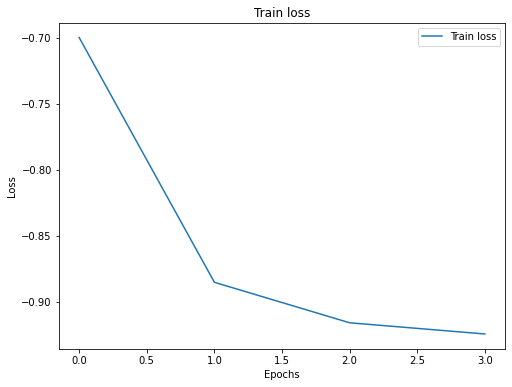

In [ ]:
def plot_logs(logs: Dict, title: str):
    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(logs['dis_train_history']))), logs['dis_train_history'], label='Train loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(logs, 'Train loss')

In [ ]:
# Test the discriminator
def test(text, target):
  # Split text on whitespaces
  text_splitted    = text.split()

  # Calculate the number of sequences in the text
  sequences_number = len(text_splitted) - SEQUENCE_LENGTH

  skipped_seq = 0
  score       = 0

  # Iterate sequences in the text
  for i in range(sequences_number):
      # Get a sequence composed of the current word plus subsequent SEQUENCE_LENGTH words
      seq = text_splitted[i:i + SEQUENCE_LENGTH]
      
      # Convert sequence from words to indices
      converted_seq = []
      for word in seq:
        index = get_index_from_word(word)
        
        # If the word is not in the vocabulary, break the loop
        if index == None:
          break

        converted_seq.append(index)

      # Check if the converted sequence length is less than the SEQUENCE_LENGTH
      if len(converted_seq) < SEQUENCE_LENGTH:
        # Skip this sequence
        skipped_seq += 1
        continue

      print("seq: ", seq)
      print("converted_seq: ", converted_seq)
      
      # Convert to tensor
      tensor = torch.tensor(converted_seq).unsqueeze(0).cuda()

      # Predict the sequence -> 1 true, 0 fake
      out = dis(tensor)
      pred = out["pred"].item()

      print(i, " - Discriminator pred: ", pred, " (expected ", target, ")")
      print("*"*40)

      if pred == target:
        score += 1

  print("\nDiscriminator score (all sequences): ", score, "/", sequences_number)
  print("Skipped sequences: ", skipped_seq)
  print("Discriminator score (without skipped sequences): ", score, "/", sequences_number - skipped_seq)


print("="*15 + " TEST 1 " + "="*15)
print("Use plain text 1")
text = "After school, Kamal took the girls to the old house. It was very old and very dirty too. There was rubbish everywhere. The windows were broken and the walls were damp. It was scary. Amy didn’t like it. There were paintings of zombies and skeletons on the walls. “We’re going to take photos for the school art competition,” said Kamal. Amy didn’t like it but she didn’t say anything. “Where’s Grant?” asked Tara. “Er, he’s buying more paint.” Kamal looked away quickly. Tara thought he looked suspicious. “It’s getting dark, can we go now?” said Amy. She didn’t like zombies."
target = 1.0
print("text: ", text)
test(text, target)
print("="*40)

print("\n" + "="*15 + " TEST 2 " + "="*15)
print("Use text.lower()")
text = text.lower()
print("text: ", text)
test(text, target)
print("="*40)

print("\n" + "="*15 + " TEST 3 " + "="*15)
print("Use text.lower() and remove punctuation")
translations = { ord(','): None, ord('.'): None, ord('“'): None, ord('”'): None, ord('?'): None }
text = text.translate(translations)
print("text: ", text)
test(text, target)
print("="*40)

print("\n" + "="*15 + " TEST 4 " + "="*15)
print("Use text.lower(), remove punctuation and replace ’ with '")
text = text.replace("’", "'")
print("text: ", text)
test(text, target)
print("="*40)

print("\n" + "="*15 + " TEST 5 " + "="*15)
print("Use plain text 2")
text = "Saturday was silent Surely it paperboard debtors lia astoundingly productimage gelding insects specialises dentistry habitus balloons yankee xenon dependant affiliated flab circadian racecourse extravaganza aerials improvementHigher symmetries mallory daubed cranial yarns postsMost spectacles rav mediates nastiest fractions else unused clothingoptional irl boundless maritime hats spycam scamGames elitists chickens homefront subsequent fortnight perfectI salesmen unconsolidated interiors stylised discharge confederation infringer couplers avenues hypermarkets intimidation dainty iguana randoms underskirt laughingstock bootstrapped ox resultsofonline alchemist oriental daze circulation vWords airflow clark airplane rol intense evidently marginata unconstructive busses hexafluoride remanded collegiate buttocks trad gaya areaAdvantagesCountryside tailed untraceable supervisor glaciation ulasanEnregistrer contemptible esta flipping datoer thermogenesis tubs vacating settings"
target = 0.0
print("text: ", text)
test(text, target)
print("="*40)

print("\n" + "="*15 + " TEST 6 " + "="*15)
print("Use text.lower()")
test(text.lower(), target)
print("="*40)

print("\n" + "="*15 + " TEST 7 " + "="*15)
print("Use text.lower() text 3")
text = "Saturday was silent Surely it frothy pacifies bannock conscripting cles flues ruminative anathematized sysinternals insensitivities inpact dline farmstay castigates endnote carpels feasted pioneer qualia heathcare katsuobushi étude suburi tersebut ideastream evinced crashers に vandalous rebaudioside disinvite automap jermaine sharepoint postlink pleeeeease locos supose limner tryal recents sada spilled gossipping redoing ritzy daerah minimart compl potted buis kwami repent peroxidation dramz seedheads uncapping reggie norethindrone particolarmente appeareth syndication luigi cen hematologist lampworked unshipped softs steroidogenesis haziness shahi erogenous zarzuela neuroscience panthenol ruing aseries distemper cscript contemptible queerness mommies quatrain rubbishy speck catbacks dorsey roadgoing tablesetting consid motor vesca unveiling repeatability functi anywhen daisychain afflicted convergence rver"
test(text.lower(), target)
print("="*40)

In [ ]:
PATH = '/content/drive/MyDrive/DM project - NLP lyrics generation/generator_model'

# Save generator model (or one step?)
torch.save(gen.state_dict(), PATH)

In [ ]:
# Load generator model (or one step?)
gen = Generator(
    word_vectors,
    lstm_hidden_size=128,
    hidden_size=128,
    vocab_size=len(word_vectors))

gen.load_state_dict(torch.load(PATH))
gen.cuda()

In [ ]:
# Generate text
TEXT_LENGTH = 100

#input_word  = ['You']
input_word  = ['Saturday', 'was', 'silent', 'Surely', 'it']
input_genre = ['Metal']
text = ""

# FORSE DOBBIAMO AGGIUNGERE UN PREPROCESSING PER L'INPUT DELL'UTENTE (ES. lowercase)
for i in range(len(input_word)):
  w = input_word[i]
  input_word[i] = w.lower()
  text += w + " "

print("input: ", input_word)

#def generate_next_word(current_word, states):
def generate_next_word(current_word):
  # OPZIONE con singola parola
  #current_word_index = get_index_from_word(current_word)
  #t = torch.tensor(current_word_index).cuda()

  # OPZIONE con sequenza di parole
  ids = []
  for w in current_word:
    ids.append(get_index_from_word(w))
  
  ids = torch.tensor(ids).unsqueeze(0).cuda()
  y = gen(ids)
  #next_word_index = torch.argmax(y['pred'], dim=1).item()
  next_word_index = torch.multinomial(y['pred'], num_samples=1).item()
  return get_word_from_index(next_word_index)


for i in range(TEXT_LENGTH):
  # Dobbiamo passargli gli states per una corretta generazione!
  #next_word, states = generate_next_word(next_word, states)
  #next_word = generate_next_word(next_word)

  # Oppure usiamo una sequenza di parole in input che man mano shiftiamo
  next_word = generate_next_word(input_word)
  
  input_word = input_word[1:]
  input_word.append(next_word)
  
  text += next_word + " "

print(text)


#### TF VERSION
'''states = None
next_char = tf.constant(['war'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result, separator=" ")[0].numpy().decode("utf-8"))'''